<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init Segmentation

##Mount Google Drive, install load packages

### Installing and loading packages 

In [1]:
#@markdown install debug packages
if False:
  !pip install -Uqq ipdb
  !pip install pympler
  !pip install psutil
  !pip install tracemalloc
  import ipdb


In [2]:
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
if False: 
  !pip uninstall torch torchvision torchaudio
!pip install torch torchvision torchaudio --upgrade -f https://download.pytorch.org/whl/cu116
!pip install fastcore --upgrade
!pip install fastai --upgrade
!pip install imageio --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True);

Mounted at /content/gdrive


### Import libraries

In [4]:
import pandas as pd
import torch
try:
  import torchvision
except:
  import importlib
  import PIL
  print("reloaded pil");
  importlib.reload(PIL);
  try:
    import torchvision
  except:
    exit();
import fastcore
import fastai
from fastai.vision.all import *
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity, adjust_gamma
from skimage.transform import resize
from typing import Callable,Dict,List,Tuple,Union
from tqdm import tqdm
import os
import numpy as np
from pathlib import Path
import re
import ntpath
import shutil
import stat

## Segmentation Parameters


### Basic Parameters
other shared settings between training and separation

In [42]:
#@markdown ### To specify a file in a bucket, prexis the path with gs://
#@markdown Whether input paths exist in a gcp bucket (will be autodetected if unset)
activate_gcp = False #@param {type:"boolean"}

def is_gcp_path(path:Path):
  return path.parts[0].lower() == "gs:";

#@markdown What object type you are segmenting
segmentation_target = "Cell" #@param ["Nucleus", "Cell", "Combined"]

#@markdown folder where processed images will be stored for training or segmentation
local_folder='local' #@param {type:"string"}
local_folder=Path(local_folder);

#@markdown folder where downloaded images will be stored temporarily for processing
temp_folder='temp' #@param {type:"string"}
temp_folder = Path(temp_folder);

#@markdown directory where models are stored and will be exported to
_modelsfolder = 'gs://optotaxisbucket/gs_test/models/fastai' #@param {type:"string"}
_modelsfolder = Path(_modelsfolder);
if is_gcp_path(_modelsfolder):
  activate_gcp = True;


training_images_folder = local_folder/"train_images"
training_masks_folder = local_folder/"train_masks"
segmentation_images_folder = local_folder/"segmentation_images"
segmentation_output_folder = local_folder/"segmentation_masks_out"
local_modelsfolder = local_folder/"models";


local_folders = [local_folder,
            training_images_folder,
            training_masks_folder,
            segmentation_images_folder,
            segmentation_output_folder,
            local_modelsfolder,
            temp_folder];

def on_rm_error( func, path, exc_info):
    # path contains the path of the file that couldn't be removed
    # let's just assume that it's read-only and unlink it.
    os.chmod( path, stat.S_IWRITE )

def cleardir(dir): #clears all files in dir without deleting dir
  for f in os.scandir(dir):
    if os.path.isdir(f): shutil.rmtree(f,onerror=on_rm_error); #just in case
    else: os.remove(f);  


for dir in local_folders:
  if not os.path.exists(dir):
    os.makedirs(dir);
  else:
    cleardir(dir);


### Image Preparation Settings
shared settings between training and segmentation image/mask processing

In [43]:
#@markdown ##Image rescaling
#@markdown Whether to scale the images and masks up/down (will be applied *after* splitting)
do_scaling = False #@param {type:"boolean"}

#@markdown Scale factor - factor by which height and width will be multiplied, final dimensions rounded to nearest integer
scale_factor = 1 #@param {type:"number"}

if not do_scaling:
  scale_factor = 1;

#@markdown **TODO:** maybe have final dimensions instead?

#@markdown ##Image Splitting and stitching
#@markdown Whether to split trained images into smaller chunks
do_splitting = True #@param {type:"boolean"} 

#@markdown Number of slices (columns/rows) to divide input images into; for the math, please see https://www.desmos.com/calculator/xrqev2vluo
x_slices = 4 #@param {type:"integer"}
y_slices =  4 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  0#@param {type:"integer"}
dy =  0#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

if not do_splitting:
  x_slices = 1;
  y_slices = 1;
  dx = 0;
  dy = 0;
  x_crop = 0;
  y_crop = 0;

context_bounds = [dy,dx]*2 #assuming x and y bounds are symmetrical to both sides of the image, which might not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x

### Training-Specific Settings
parameters and paths only for training

In [44]:
#@markdown ## Training Source
#@markdown location - zip file or folder - where input images are stored
_training_images="/content/gdrive/Othercomputers/UNC Laptop/iter1/round10/images" #@param {type:"string"}
_training_images=Path(_training_images);

#@markdown input folder where masks are stored (will not be edited)
_training_masks="/content/gdrive/Othercomputers/UNC Laptop/iter1/round10/masks" #@param {type:"string"}
_training_masks=Path(_training_masks);

if (is_gcp_path(_training_images) or is_gcp_path(_training_masks)):
  activate_gcp = True;

#@markdown UNET model that will be used to train from, relative to modelsfolder. if left blank, a new model will be created
inmodelname = 'iter1_9_continue.pkl' #@param {type:"string"}
#@markdown where the model will be exported to after training, in modelsfolder (if modelsfolder is gcp, will also update)
outmodelname = 'iter1_10_continue.pkl' #@param {type:"string"}

#@markdown ## Training Data Augmentation

#@markdown ### Gamma (avg brightness) adjustments
do_gamma = False #@param {type:"boolean"}
gamma_aug_list = [0.5,0.8,1,1.2,1.5] #@param {type:"raw"}

### Segmentation-Specific Settings:
parameters and paths only for segmenting an experiment


In [45]:
#@markdown Path of the folder containing the movies in GCP bucket
_segmentation_images="/content/gdrive/Othercomputers/UNC Laptop/iter1/round11/images"  #@param {type:"string"}
_segmentation_images=Path(_segmentation_images);

#@markdown name of the model used to segment
segment_model_name="iter1_9_continue.pkl" #@param {type:"string"}

#@markdown path of the folder where the output masks will be deposited. if in gcp bucket (prefix with gs://), will be exported
_segmentation_output_masks='/content/gdrive/Othercomputers/UNC Laptop/iter1/round11/input2' #@param {type:"string"}
_segmentation_output_masks=Path(_segmentation_output_masks);

if is_gcp_path(_segmentation_images) or is_gcp_path(_segmentation_output_masks):
  activate_gcp = True;




### Activate GCP if necessary

In [46]:
if activate_gcp:
  from google.colab import auth
  #This allows SDK to see and edit Google Drive files
  #SDK is required to interact with GCP
  auth.authenticate_user()

## Shared helper functions

### File Transfer / Management

In [47]:

def _fetch_gcp_files(in_path:Path,keyword:str,overwrite:bool)->Path: ##should not be called outside of other helper functions
  is_file = str(in_path).lower().endswith(('.zip','.tif','.tiff'));
  destination = temp_folder/keyword/in_path.stem;
  if not(os.path.exists(destination)):
    os.makedirs(destination);
  # copy_out = Path(destination)/in_path.name;
  command_output = None;
  if (is_gcp_path(in_path)): #first part is gs:, must be removed to work with gcloud
    in_path = Path(*in_path.parts[1:])
  if overwrite or len(os.listdir(destination)) == 0:
    if is_file:
      command_output = !gsutil -m cp -r "gs://{in_path}" "{destination}"
    else:
      command_output = !gsutil -m rsync -r "gs://{in_path}" "{destination}"
  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while downloading {keyword} from bucket: " + '\n'.join(command_output));
  elif len(os.listdir(destination)) == 0:
    raise RuntimeError("Error: downloading failed for an unknown reason; Command Output:",command_output);
  if (not is_file):
    return destination; #we're done
  else:
    destination = destination/in_path.name;
  if (in_path.suffix == '.zip'):
    out_path = destination.with_suffix('');
    command_output = None;
    if (overwrite or not os.path.exists(out_path)):
      command_output = !unzip -o "{destination}" -d "{destination.parent}"
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while unzipping {keyword}: " + '\n'.join(command_output));
    elif not os.path.exists(out_path):
      raise RuntimeError(f"Error while unzipping (from GCP): zip file {destination.name} does not contain folder {destination.with_suffix('').name}");
    return out_path;
  elif (in_path.suffix.lower().startswith('.tif')):
    raise NotImplementedError("unstacking TIF files not yet supported");
  else:
    raise NameError("Invalid input suffix, input validation should have caught this >:(");

def _push_gcp_files(in_folder:Path,out_path:Path,keyword:str,overwrite:bool):
  assert os.path.isdir(in_folder); 
  if (is_gcp_path(out_path)): #first part is gs:, must be removed to work with gcloud
    out_path = Path(*out_path.parts[1:])
  
  command_output = None;

  if (out_path.suffix != ''): #file
    in_file = None;
    if (out_path.suffix.lower() == '.zip'):
      command_output = !zip "{temp/keyword/zip/out_path.name}"  "{in_folder}"
      if (command_output is not None and command_output[0].startswith("CommandException")):
        raise RuntimeError(f"Error while zipping {keyword} folder {in_folder} to zip file: " + '\n'.join(command_output));
      in_file = temp_folder/keyword/zip/out_path.name;
    elif (out_path.suffix.lower().startswith('.tif')):
      raise NotImplementedError("stacking TIF files not yet supported");
    else:
      raise NameError("Invalid output suffix; can only zip or stack tiffs. If the output is a directory, please do not add a file suffix.")

    if overwrite:
      command_output = !gsutil -m cp -r "{in_file}" "gs://{out_path}"
    else:
      command_output = !gsutil -m cp -r -n "{in_file}" "gs://{out_path}"
  else: #upload entire directory
    command_output = !gsutil -m rsync -r "{in_folder}" "gs://{out_path}"

  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while uploading {keyword} to bucket: " + '\n'.join(command_output));
  return


In [48]:
_keyword_map = {"models":(_modelsfolder,local_modelsfolder),
               "train_images":(_training_images,training_images_folder),
               "train_masks":(_training_masks,training_masks_folder),
               "segmentation_images":(_segmentation_images,segmentation_images_folder),
               "segmentation_masks":(_segmentation_output_masks,segmentation_output_folder)};

_keyword_sources:Dict[str,Union[None,Path]] = {name:None for name in _keyword_map};

In [49]:
def _fetch_sourcefolder(keyword,overwrite=True)->Path: 
  """returns the folder with the raw files, after unzip and or download if necessary."""
  if (not overwrite and _keyword_sources[keyword] is not None):
    return _keyword_sources[keyword];
  source = _keyword_map[keyword][0];
  result = source;
  if (is_gcp_path(source)):
    result = _fetch_gcp_files(source,keyword,overwrite=True);
  elif (source.suffix == '.zip'):
    destination = temp_folder/keyword;
    os.mkdir(destination);
    command_output = !unzip -o "{source}" -d "{destination}"
    result = destination/source.stem;
    if (not os.path.exists(result)):
      raise RuntimeError(f"Error while unzipping: zip file {source} does not contain folder {source.stem}");
  if (_keyword_sources[keyword] is not None and _keyword_sources[keyword] != result):
    raise RuntimeError(f"Error fetching sourcefolder for keyword {keyword}: sourcefolder already exists in a different location - are you pushing before you fetch?");
  _keyword_sources[keyword] = result;
  return result;

def _push_sourcefolder(keyword,overwrite=True): 
  """inverse of fetch_sourcefolder - zips sourcefolder to original location or pushes to gcp if appropriate, otherwise noop"""
  sourcefolder = _keyword_sources[keyword];
  if (sourcefolder is None):
    raise RuntimeError("")
  dest = _keyword_map[keyword][0];
  if (is_gcp_path(dest)):
    _push_gcp_files(sourcefolder,dest,keyword,overwrite=overwrite);
  elif (dest.suffix == '.zip'):
    raise NotImplementedError("local sourcefolder zipping not implemented");
  pass;

proc_type = Callable[[str,np.ndarray],Union[Tuple[str,np.ndarray],List[Tuple[str,np.ndarray]]]]
#this allows splitting or stitching of images; splititng returns multiple images, stitching can return [] for all images concatenated into a larger one

def _decopy_local(keyword:str,push_source=True):
  dest = _keyword_sources[keyword] or temp_folder/keyword/_keyword_map[keyword][0].stem;
  _keyword_sources[keyword] = dest;
  local = _keyword_map[keyword][1];

  command_out = !gsutil -m rsync "{local}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);
  
  if push_source:
    _push_sourcefolder(keyword);

def _deprocess_images(keyword:str,deprocess_fn:proc_type,push_source=True):
  dest = _keyword_sources[keyword]
  if dest is None:
    p_source = _keyword_map[keyword][0]; #p for prospective
    print("checking prospective source",p_source);
    if (is_gcp_path(p_source) or p_source.is_file()):
      print("file/gcp found: requires temp folder")
      dest = temp_folder/keyword/_keyword_map[keyword][0].stem;
      _keyword_sources[keyword] = dest;
      if not os.path.exists(dest):
        os.makedirs(dest);
    else:
      print("not file nor gcp: writing directly to source");
      _keyword_sources[keyword] = p_source;
      dest = p_source

  local = _keyword_map[keyword][1];

  for im in tqdm(os.listdir(local)):
    path = local/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
      print(f"non-image file in {keyword} dir:",im);
      continue;
    try:
      image = imread(path);
    except:
      raise RuntimeError("unable to read image",path);
    processed = deprocess_fn(im,image);
    if (not isinstance(processed,list)):
      processed = [(im,processed)];
    for name,p in processed:
      # print("saving to",dest/name);
      imsave(dest/name,p,check_contrast=False);

  if push_source:
    _push_sourcefolder(keyword);

def _copy_local(keyword:str,overwrite_source=False):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest = _keyword_map[keyword][1];
  
  command_out = !gsutil -m rsync "{source}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);
  return dest;

def _process_images(keyword:str,process_fn:proc_type,overwrite_source=False):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest =_keyword_map[keyword][1];
  if any(os.scandir(dest)):
    cleardir(dest);

  for im in tqdm(os.listdir(source)):
    path = source/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
      print(f"non-image file in {keyword} dir:",im);
      continue;
    image = imread(path);
    # imsave(temp_folder/"dum"/im,image);
    processed = process_fn(im,image);
    if (not isinstance(processed,list)):
      processed = [processed];
    for name,p in processed:
      imsave(dest/name,p,check_contrast=False);
      
  return dest;

def no_op(name:Any,inp:Any):
  return (name,inp);

def process_train_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("train_images",process_fn,overwrite_source=overwrite_source);

def process_segmentation_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("segmentation_images",process_fn,overwrite_source=overwrite_source);

def process_train_masks(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("train_masks",process_fn,overwrite_source=overwrite_source);

def deprocess_sementation_masks(process_fn:proc_type=no_op):
  _deprocess_images("segmentation_masks",process_fn,push_source=True);

def fetch_modelsfolder(overwrite=False):
  return _copy_local("models",overwrite_source=overwrite);

def push_modelsfolder(fetch=False):
  if (fetch):
    fetch_modelsfolder(overwrite=False);
  return _decopy_local("models",push_source=True);

def push_segmentation_folder():
  return _push_sourcefolder("segmentation_masks")

In [50]:
from typing import DefaultDict
nameless_proc_type = Union[Callable[[np.ndarray],Union[np.ndarray,List[np.ndarray]]],Callable[[List[np.ndarray]],Union[np.ndarray,List[np.ndarray]]]]
class Enumerator: #simple in-out mapper for splitting/stitching like operations
  @classmethod
  def create(cls,process_fn:nameless_proc_type,enum_in:bool=False):
    """creates an Enumerator class to process named images with a simple numbering scheme; returns processing function to give to process/deprocess images
    args:
    - process_fn: function that processes image (or ordered set of output images from another enumerator) and returns an image or list of images to be enumerated
    - enum_in (optional): whether process_fn inputs a single image or an enumerated list
    """
    enum = cls(process_fn,enum_in);
    return enum.process;
  
  def __init__(self,proc_fn:nameless_proc_type,enum_in:bool,delimiter:str='-'):
    self.proc = proc_fn;
    self.m_in = enum_in;
    self.delim = delimiter;
    self.queue = DefaultDict(lambda: {});

  def process(self,name:str,image:np.ndarray):
    name,ext = os.path.splitext(name);
    if (self.m_in):
      spl = name.rindex(self.delim)
      base = name[:spl];
      num = name[spl+len(self.delim):];
      if num.endswith('f'):
        num = num[:-1]
        listed = [None for _ in range(int(num)+1)];
        for n,im in self.queue[base].items():
          listed[n] = im;
        self.queue[base] = listed
      
      num = int(num);
      self.queue[base][num] = image;
      return [(s + ext,i) for s,i in sum((self._format_out(n,self.proc(t)) for n,t in self.flush_queue()),[])];
    else:
      return [(n + ext,i) for n,i in self._format_out(name,self.proc(image))];

  def _format_out(self,name:str,out:Union[np.ndarray,List[np.ndarray]]):
    if (isinstance(out,list)):
      return [(f"{name}{self.delim}{i}" + ("f" if i == len(out)-1 else ""),m) for i,m in enumerate(out)];
    else:
      return [(name,out)];

  def flush_queue(self):
    complete = [];
    for name,tiles in self.queue.items():
      if isinstance(tiles,list) and all([None is not t for t in tiles]): #final found, all tiles full
         complete.append(name);
        #  print("image complete:",name);
         yield (name,tiles);
    
    for n in complete:
      del self.queue[n];         


In [51]:
def _proc_wrap(func:proc_type):
  def wrapped(name:str,image:np.ndarray):
    o = func(name,image);
    if (not isinstance(o,list)):
      o = [o];
    return o;
  return wrapped;

def _proc_compose(f1:proc_type,f2:proc_type):
  wf1 = _proc_wrap(f1);
  wf2 = _proc_wrap(f2);
  def composed(name:str,image:np.ndarray):
    return sum([wf2(n,i) for n,i in wf1(name,image)],[])
  return composed;

def _im_wrap(func):
  def wrapped(image:np.ndarray):
    o = func(image);
    if (not isinstance(o,list)):
      o = [o];
    return o;
  return wrapped;

def _compose(f1,f2):
  wf1 = _im_wrap(f1);
  wf2 = _im_wrap(f2);
  def composed(image:np.ndarray):
    return sum([wf2(i) for i in wf1(image)],[])
  return composed;

def compose_proc_functions(funcs:List[proc_type]):
  return functools.reduce(_proc_compose,funcs);

def compose_im_functions(funcs:List[nameless_proc_type]):
  return functools.reduce(_compose,funcs);


### Image Preparation

In [52]:
def prepare_image(image:np.ndarray):
    image = rescale_intensity(image);
    if (image.dtype != "uint8"):
      image = (image/256).astype('uint8');
    if (len(image.shape) != 3 or image.shape[2] != 3):
      image = np.stack((image,image,image),axis=2);
    return image

def prepare_mask(mask:np.ndarray):
  #TODO: update for combined masks
  if (len(mask.shape) == 3):
    mask = mask[:,:,0];
  mask[mask>0] = 1;
  mask[mask<=0] = 0;
  mask = mask.astype('uint8');
  return mask;


### Image splitting / stitching

In [53]:
def create_split_image_process_fn(x_slices,y_slices,context_bounds,crop):
  def split_image(im:np.ndarray):  
    M = (im.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
    N = (im.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;

    if int(M) != M or int(N) != N:
        raise Exception(f"ERROR: Image with size {im.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
    else:
        M = int(M)
        N = int(N)
        tiles = [im[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]] 
                for y in range(context_bounds[0]+crop[0],im.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                for x in range(context_bounds[1]+crop[1],im.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
        return tiles
  return split_image

def create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop):
  def stitch_image(tiles:Union[List[Tensor],List[np.ndarray]]):
    stitchMasks = []
    for i,m in enumerate(tiles):
        if isinstance(m,Tensor):
          m = m.numpy().astype('uint8')
        y = i // x_slices;
        x = i % x_slices;
        imBounds = [crop[0]+context_bounds[0] if y != 0 else 0,m.shape[0]-crop[2]-context_bounds[2] if y != y_slices-1 else m.shape[0],crop[1]+context_bounds[1] if x != 0 else 0 ,m.shape[1]-crop[3]-context_bounds[3] if x != x_slices - 1 else m.shape[1]];
        stitchMasks.append(m[imBounds[0]:imBounds[1],imBounds[2]:imBounds[3]]);
    stitched = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
    return stitched
  return stitch_image;

### Misc Processing Functions


In [54]:
def create_scale_image_process_fn(scale_factor:float):
  def scale_image(image:np.ndarray):
    return resize(image,[scale_factor*t for t in image.shape]);
  return scale_image;

In [55]:
def create_gamma_image_process_fn(gammas:List[float]):
  def gammafy_image(image:np.ndarray):
    return [adjust_gamma(image,gamma) for gamma in gammas];
  return gammafy_image;
  

In [56]:
def create_duplicate_process_fn(num_duplicates:int):
  def duplicate_image(image:np.ndarray):
    return [image for _ in range(num_duplicates)]
  return duplicate_image

# Preparing data for trainining

### Prepare images and masks for training (see Image Preparation Settings)

In [32]:
comp_fns = [];

if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

if do_scaling:
  comp_fns.append(create_scale_image_process_fn(scale_factor))

im_comp_fns = [prepare_image,*comp_fns];
mask_comp_fns = [prepare_mask,*comp_fns];

if do_gamma:
  im_comp_fns.append(create_gamma_image_process_fn(gamma_aug_list))
  mask_comp_fns.append(create_duplicate_process_fn(len(gamma_aug_list)))

im_proc_fn = Enumerator.create(compose_im_functions(im_comp_fns));
mask_proc_fn = Enumerator.create(compose_im_functions(mask_comp_fns))

process_train_masks(mask_proc_fn)
process_train_images(im_proc_fn);

  0%|          | 0/19 [00:00<?, ?it/s]<ipython-input-27-78050cebaa8e>:106: UserWarning: temp/dum/p_s2_t89.TIF is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(temp_folder/"dum"/im,image);
<ipython-input-27-78050cebaa8e>:106: UserWarning: temp/dum/p_s2_t89.TIF is a low contrast image
  imsave(temp_folder/"dum"/im,image);
<ipython-input-27-78050cebaa8e>:106: UserWarning: temp/dum/p_s3_t78.TIF is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(temp_folder/"dum"/im,image);
<ipython-input-27-78050cebaa8e>:106: UserWarning: temp/dum/p_s3_t79.TIF is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(temp_folder/"dum"/im,image);
<ipython-input-27-78050cebaa8e>:106: UserWarning: temp/dum/p_s6_t63.TIF is a boolean image: setting True to 255 and Fals

###Prepare fast.ai data loader

In [33]:
def mask_from_image(im_path:Path):
  rpath = im_path.relative_to(training_images_folder);
  p = training_masks_folder/rpath.with_suffix('.tif');
  if (os.path.exists(p)):
    return p;
  p = p.with_suffix('.TIF');
  if (os.path.exists(p)):
    return p;
  raise RuntimeError(f"Unable to find corresponding mask for image {im_path} in masks directory")

In [34]:
trainingset = DataBlock(blocks=[ImageBlock, MaskBlock],
                   get_items = get_image_files,
                   get_y = mask_from_image,
                   splitter=RandomSplitter())

In [35]:
dls = trainingset.dataloaders(training_images_folder, bs=4);


#Training

In [36]:
fetch_modelsfolder();

In [37]:
def label_func(): pass;
if inmodelname:
  loadedlearner=load_learner(local_modelsfolder/inmodelname);
  loadedlearner.dls=dls 
else:
  loadedlearner=unet_learner(dls,resnet34,n_out=(2 if segmentation_target != "Combined" else 3));

loadedlearner.loss_func.func.label_smoothing = 0.0; #fix bug where pickled crossentropyloss contained within learner has insufficient variables
torch.cuda.empty_cache();

In [38]:
!nvidia-smi

Sun Feb  5 20:31:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    28W /  70W |    570MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Common errors and solutions:
- cuDNN cuda not initialized: bad torch version
- memory issues (including no convolution algorithm - check that images are being scaled to 8-bit)
--- most memory issues come from high memory usage during single evaluations of the model with backpropagation, overloading ram or gpu memory. Might need to slice the images into smaller sections for this to work
[link](/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py)


In [44]:
loadedlearner.fine_tune(5)
raise Exception()

epoch,train_loss,valid_loss,time
0,0.011318,0.025611,00:20


epoch,train_loss,valid_loss,time
0,0.009005,0.022767,00:22
1,0.008897,0.023789,00:21
2,0.007920,0.025114,00:22
3,0.006920,0.027284,00:21
4,0.005917,0.028717,00:21


Exception: ignored

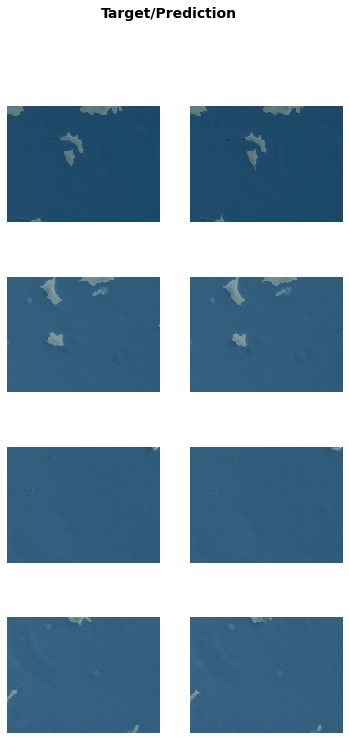

In [46]:
loadedlearner.show_results(max_n=17)

In [43]:
# loadedlearner.dls = None;
loadedlearner.export(fname=local_modelsfolder/outmodelname, pickle_protocol=2);
push_modelsfolder();

# Segment Experiment - Google Drive
Will process each folder and subfolder individually. Works great with large numbers of images split into subfolders (like stage positions) and with small numbers of images in the main folder. Pulls data from google drive.

### Loading a trained model

In [57]:
print("available cpu count:",len(os.sched_getaffinity(0)));

available cpu count: 2


In [58]:
fetch_modelsfolder();
def label_func(x): return None; ##dummy functions to make unpickling work, never used
def mask_from_image(x): return None
loadedlearner=load_learner(local_modelsfolder/segment_model_name);
if torch.cuda.is_available():
  print("using gpu");
  loadedlearner.model = loadedlearner.model.cuda();


using gpu


### Prepare Images for segmentation

In [59]:
comp_fns = [];

if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

if do_scaling:
  comp_fns.append(create_scale_image_process_fn(scale_factor))

im_comp_fns = [prepare_image,*comp_fns];

im_proc_fn = Enumerator.create(compose_im_functions(im_comp_fns));

process_segmentation_images(im_proc_fn);

100%|██████████| 30/30 [00:02<00:00, 13.28it/s]


In [60]:
## prepare input file reading
subfolders = [ Path(f.path) if f.is_dir() else None for f in os.scandir(segmentation_images_folder)  ]
toplevel_images = False;
if None in subfolders:
  subfolders = [s for s in subfolders if s is not None];
  toplevel_images = True;
corresponding_outs = [segmentation_output_folder];
if len(subfolders) == 0:
  subfolders = [segmentation_images_folder];
  toplevel_images = True;
else:
  corresponding_outs = [segmentation_output_folder/f.name for f in subfolders];
  if toplevel_images:
    subfolders.append(segmentation_images_folder);
    corresponding_outs.append(segmentation_output_folder);
  for c in corresponding_outs:
    if not(os.path.exists(c)):
      os.mkdir(c);

batchSize = 32; 

folderChunks = [];
sub_lengths = [];
for f,out in zip(subfolders,corresponding_outs):
  print("pulling files from",os.path.basename(f))
  files = get_image_files(f);
  completed_masks = os.listdir(out);
  print("input files:",len(files))
  print("output files:",len(completed_masks))
  files = [fi for fi in files if os.path.basename(fi) not in completed_masks];
  print("remaining files:",len(files))
  sub_lengths.append(len(files));

  folderChunks.append(chunked(files, chunk_sz=batchSize));


pulling files from segmentation_images
input files: 480
output files: 0
remaining files: 480


### Segment images

In [61]:
with torch.no_grad():
  for fileChunks,outFolder,num,f in zip(folderChunks,corresponding_outs,sub_lengths,subfolders):
    print("in:",os.path.basename(f),"out:",os.path.basename(outFolder),"count:",num);
    for chunk in progress_bar(fileChunks,num//batchSize+1):
      dl = loadedlearner.dls.test_dl(chunk,num_workers=len(os.sched_getaffinity(0)));
      if torch.cuda.is_available():
        dl = loadedlearner.dls.test_dl(chunk,num_workers=len(os.sched_getaffinity(0)),device='cuda');
        dl.to('cuda');
      _,_,dec_preds = loadedlearner.get_preds(with_decoded=True,dl=dl);
      for path,prediction in zip(chunk,dec_preds):
        basename = os.path.basename(path);
        im = prediction.numpy().astype('uint8');
        # print(im.min(),im.max());
        imsave(outFolder/basename,im,check_contrast=False);
    with open(outFolder/'segmentation_complete.flag','w') as f:
      pass;
    print("folder processing complete");

in: segmentation_images out: segmentation_masks_out count: 480


folder processing complete


### Deprocess and Export Masks

In [63]:
comp_fns = [];

#no splitting for segmentation - maybe add separate setting?

if do_scaling:
  comp_fns.append(create_scale_image_process_fn(1/scale_factor))

if do_splitting:
  comp_fns.append(create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop));

mask_deproc_fn = Enumerator.create(compose_im_functions(comp_fns),enum_in=do_splitting);

deprocess_sementation_masks(mask_deproc_fn);

 68%|██████▊   | 326/481 [00:00<00:00, 1047.58it/s]

non-image file in segmentation_masks dir: segmentation_complete.flag


100%|██████████| 481/481 [00:00<00:00, 597.50it/s]
